# FineTuning de modelos de lenguaje generativos: Falcon

## Instalación de dependencias y preparación del kernel

In [ ]:
# !pip install -q -U torch=='2.0.0'

In [ ]:
# !pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' transformers=='4.36.1' trl=='0.7.4'

In [ ]:
!pip install bitsandbytes
!pip install pytorch_lightning
!pip install datasets
!pip install trl
!pip install optuna

#### Limpiar caché

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything
from tqdm import tqdm
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging,
                          EarlyStoppingCallback)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from huggingface_hub import login

import optuna
import optuna.visualization as vis
import gc

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_everything(42, workers=True)
pd.set_option('display.max_colwidth', None)

In [ ]:
# Comprobar GPU
if torch.cuda.device_count() > 0:
    print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
    device = torch.device("cuda")
else:
    print('Currently using CPU. To utilize GPU acceleration, change the runtime type in the \'runtime\' tab.')

## Preparación del conjunto de datos

#### Carga de datos

In [ ]:
# Montar directorio de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset Canciones
train_filename = "/content/drive/MyDrive/Colab Notebooks/data/train.csv"
test_filename = "/content/drive/MyDrive/Colab Notebooks/data/test.csv"
valid_filename = "/content/drive/MyDrive/Colab Notebooks/data/eval.csv"
campo_texto = 'text'
campo_etiqueta = 'intent'
clase_0 = 'add'
clase_1 = 'remove'
clase_2 = 'view'
clase_3 = 'clear'


In [ ]:
# Cargar los conjuntos de datos de entrenamiento, prueba y validación
def load_data(train_file, test_file, valid_file):
    X_train = pd.read_csv(train_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
    X_test = pd.read_csv(test_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
    X_eval = pd.read_csv(valid_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
    return X_train, X_test, X_eval

train_df, test_df, valid_df = load_data(train_filename, test_filename, valid_filename)

In [ ]:
X_train, X_test, X_eval = train_df, test_df, valid_df
Y_true = X_test[campo_etiqueta]

#### Mezclar y reorganizar los datos

In [ ]:
# Mezclar y reiniciar índices de los conjuntos de datos
def shuffle_and_reset_index(data, seed = 10):
    return data.sample(frac = 1, random_state = seed).reset_index(drop = True)

X_train = shuffle_and_reset_index(X_train)
X_eval = shuffle_and_reset_index(X_eval)
X_test = X_test.reset_index(drop = True)

#### Visualización de la distribución de clases

In [ ]:
# Mostrar la distribución de clases en los conjuntos de datos
def show_class_distribution(data, name):
    print(f"\nDistribución de clases en el conjunto de {name}:")
    print(data[campo_etiqueta].value_counts())

show_class_distribution(X_train, "entrenamiento")
show_class_distribution(X_test, "prueba")
show_class_distribution(X_eval, "validación")


Distribución de clases en el conjunto de entrenamiento:
intent
remove    272
add       272
clear     272
view      272
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
intent
add       80
view      80
clear     80
remove    80
Name: count, dtype: int64

Distribución de clases en el conjunto de validación:
intent
clear     48
add       48
view      48
remove    48
Name: count, dtype: int64


#### Generación de Prompts

In [ ]:
i_prompt = 0
prompts = [ f"""
            [INST]
            Analyze the following text input to determine the user's intent.
            Consider the content, wording, and possible implicit or explicit intentions behind the request.

            Classify the input into one of the following categories:
            - view
            - clear
            - remove
            - add

            Return exclusively **only** the corresponding category as a single word, with no additional text.
            [/INST]  """,
          ]

In [ ]:
# Funciones para generar los prompts de entrenamiento y prueba
def generate_prompt(data_point, prompt):
    return f"""
            {prompt}

            [USER: {data_point[campo_texto]}] = {data_point[campo_etiqueta]} """.strip()

def generate_test_prompt(data_point, prompt):
    return f"""
            {prompt}

            [{data_point[campo_texto]}] = """.strip()

# Aplicar la generación de prompts a los conjuntos de datos
X_train = pd.DataFrame(X_train.apply(lambda row: generate_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])
X_eval = pd.DataFrame(X_eval.apply(lambda row: generate_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])

Y_true = X_test.intent
X_test = pd.DataFrame(X_test.apply(lambda row: generate_test_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])

In [ ]:
X_train.head()

,text
0,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [USER: Can you delete 'Memories' by Drake?] = remove"
1,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [USER: Add 'Bad Guy' by Billie Eilish.] = add"
2,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [USER: Remove every item from my playlist.] = clear"
3,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [USER: Please clear my entire playlist] = clear"
4,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [USER: Wipe all songs from my playlist.] = clear"


In [ ]:
X_test.head()

,text
0,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Add 'Come As You Are' by Nirvana.] ="
1,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Add 'Sunflower' by Harry Styles.] ="
2,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Can you show me the saved songs in my playlist?] ="
3,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Please list the songs in my playlist.] ="
4,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Remove every single song] ="


#### Conversión a Dataset de HuggingFace

In [ ]:
# Convertir a Dataset de HuggingFace
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
test_data = Dataset.from_pandas(X_test)

In [ ]:
train_data

Dataset({
    features: ['text'],
    num_rows: 1088
})

In [ ]:
eval_data

Dataset({
    features: ['text'],
    num_rows: 192
})

In [ ]:
test_data

Dataset({
    features: ['text'],
    num_rows: 320
})

## Funcion de evaluación

In [ ]:
def evaluate(y_true, y_pred, metodo):
    labels = [clase_0, clase_1, clase_2, clase_3]
    mapping = {
    "add": 0,
    "remove": 1,
    "view": 2,
    "clear": 3
    }


    # Convertir etiquetas a valores numéricos usando mapeo eficiente
    y_true = pd.Series(y_true).map(mapping).fillna(0).astype(int)
    y_pred = pd.Series([labels[i] for i in y_pred]).map(mapping).fillna(0).astype(int)

    # Calcular precisión global
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generar y mostrar el reporte de clasificación completo
    print('\nClassification Report:')
    class_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=labels))

    # Generar y mostrar la matriz de confusión
    print('\nConfusion Matrix:')
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Reorganizar la matriz de confusión si es necesario
    conf_reordered = conf_matrix  # Puedes ajustar el orden si lo necesitas

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_reordered, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(f'Matriz Confusion - {i_model} (Prompt {i_prompt}). {metodo}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Guardar la matriz de confusión
    matriz_path = f'/content/drive/MyDrive/Colab Notebooks/matrices/matriz_{i_model}_prompt{i_prompt}_{metodo}.jpeg'
    plt.savefig(matriz_path)
    plt.show()

    # Extraer métricas del reporte de clasificación
    precision_3 = class_report[clase_3]['precision']
    recall_3 = class_report[clase_3]['recall']
    f1_score_3 = class_report[clase_3]['f1-score']
    support_3 = class_report[clase_3]['support']

    precision_2 = class_report[clase_2]['precision']
    recall_2 = class_report[clase_2]['recall']
    f1_score_2 = class_report[clase_2]['f1-score']
    support_2 = class_report[clase_2]['support']

    precision_1 = class_report[clase_1]['precision']
    recall_1 = class_report[clase_1]['recall']
    f1_score_1 = class_report[clase_1]['f1-score']
    support_1 = class_report[clase_1]['support']

    precision_0 = class_report[clase_0]['precision']
    recall_0 = class_report[clase_0]['recall']
    f1_score_0 = class_report[clase_0]['f1-score']
    support_0 = class_report[clase_0]['support']

    # Asegurarse de que las métricas y la matriz se devuelvan correctamente
    return {
        'accuracy': accuracy,
        'precision_3': precision_3,
        'recall_3': recall_3,
        'f1_score_3': f1_score_3,
        'support_3': support_3,
        'precision_2': precision_2,
        'recall_2': recall_2,
        'f1_score_2': f1_score_2,
        'support_2': support_2,
        'precision_1': precision_1,
        'recall_1': recall_1,
        'f1_score_1': f1_score_1,
        'support_1': support_1,
        'precision_0': precision_0,
        'recall_0': recall_0,
        'f1_score_0': f1_score_0,
        'support_0': support_0,
        'matriz_path': matriz_path
    }


## Uso del modelo

#### Definición de hiperparámetros

In [ ]:
num_epochs = 60
num_epochs_bloque = 3

#### Enumeración de modelos

In [ ]:
i_model = 1
model_names = ['meta-llama/Llama-3.2-1B-Instruct', 'tiiuae/falcon-7b']
model_shorts = ['llama-1b', 'falcon-7b']

In [ ]:
metodo1 = 'Base'
metodo2 = 'PreprocesadoES'

#### Configuración del modelo y carga de tokenizer

In [ ]:
# Token de Hugging Face
hf_token = ""
login(hf_token)

In [ ]:
def load_model_and_tokenizer(model_name, hf_token=None, quantization=True):
    try:
        # Configuración de cuantización en 4 bits
        if quantization:
            compute_dtype = getattr(torch, "float16")
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=False,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=compute_dtype,
            )
        else:
            bnb_config = None  # Sin cuantización

        # Cargar modelo con configuración de cuantización
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
            use_auth_token=hf_token,
        )

        # Configuraciones adicionales específicas del modelo
        if hasattr(model.config, "use_cache"):
            model.config.use_cache = False
        if hasattr(model.config, "pretraining_tp"):
            model.config.pretraining_tp = 1  # Modelos LLaMA

        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=True,
            padding_side="left",
            add_eos_token=True,
            use_auth_token=hf_token,
        )
        tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer

    except Exception as e:
        print(f"Error al cargar el modelo {model_name}: {e}")
        return None, None

In [ ]:
# Llamada a la función
model_name = model_names[i_model]
model, tokenizer = load_model_and_tokenizer(model_name)

#### Función de predicción

In [ ]:
X_test

,text
0,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Add 'Come As You Are' by Nirvana.] ="
1,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Add 'Sunflower' by Harry Styles.] ="
2,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Can you show me the saved songs in my playlist?] ="
3,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Please list the songs in my playlist.] ="
4,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Remove every single song] ="
...,...
315,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Clear the entire playlist, all songs included.] ="
316,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Please remove 'Uptown Funk' by Mark Ronson from the playlist.] ="
317,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Add 'Hey Jude' to my music.] ="
318,"[INST]\n Analyze the following text input to determine the user's intent.\n Consider the content, wording, and possible implicit or explicit intentions behind the request.\n\n Classify the input into one of the following categories:\n - view\n - clear\n - remove\n - add\n\n Return exclusively **only** the corresponding category as a single word, with no additional text.\n [/INST] \n\n [Remove 'I Don’t Want to Miss a Thing' by Aerosmith from the saved songs.] ="


In [ ]:
# Función de predicción
def predict(X_test, model, tokenizer):
    y_pred = []

    # Crear pipeline de generación de texto
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=3,
        do_sample=False,
        return_full_text=False,
        truncation=True
    )

    # Iterar sobre los ejemplos del dataset de prueba
    for i in tqdm(range(len(X_test))):
        prompt = X_test[i][campo_texto]

        # Agregar token especial para evitar problemas de caracteres extraños
        result = pipe(prompt, pad_token_id=tokenizer.eos_token_id)
        if not result or 'generated_text' not in result[0]:
            print(f"Warning: No generated text for prompt '{prompt}', using default class.")
            y_pred.append(0)
            continue  # Saltar a la siguiente iteración

        # Limpiar texto generado
        generated_text = re.sub(r'[^a-z]', ' ', result[0]['generated_text'].strip().lower()).strip()
        words = generated_text.split()
        if not words:  # Verificar si la lista está vacía
            print(f"Warning: No valid words generated for '{prompt}', using default class.")
            y_pred.append(0)
            continue

        generated_text = words[0]  # Tomar solo la primera palabra
        print(generated_text)

        # Filtrar la respuesta generada y buscar etiquetas específicas add, remove, clear, view
        if generated_text == clase_3.lower():
            y_pred.append(3)
        elif generated_text == clase_2.lower():
            y_pred.append(2)
        elif generated_text == clase_1.lower():
            y_pred.append(1)
        elif generated_text == clase_0.lower():
            y_pred.append(0)
        else:
            y_pred.append(0)  # Default

    return y_pred


### Prueba Zero Shot con el modelo base

In [ ]:
# Función de evaluación
Y_pred = predict(test_data, model, tokenizer)
evaluate(Y_true, Y_pred, metodo1)

#### Configuración de PEFT (LoRA)

In [ ]:
from peft import LoraConfig

# Configuración de LoRA (PEFT)
def setup_peft():
    peft_config = LoraConfig(
        lora_alpha = 16,
        lora_dropout = 0.05,
        r = 64,
        bias = "none",
        task_type = "CAUSAL_LM"
    )
    return peft_config

peft_config = setup_peft()

# Entrenamiento del modelo

In [ ]:
print(f"Memoria libre: {torch.cuda.memory_reserved() / 1e9} GB")
print(f"Memoria total: {torch.cuda.memory_allocated() / 1e9} GB")

In [ ]:
torch.cuda.empty_cache()

## Optimización de hiperparámetros

In [ ]:
# Ruta local y en Drive
local_db = "optunaFalcon_study.db"
drive_db = "/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/optunaFalcon_study.db"

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-6, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.4, 5.0)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.3)
    per_device_train_batch_size = trial.suggest_int("per_device_train_batch_size", 4, 8)
    gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 1, 4)

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        max_grad_norm=max_grad_norm,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        logging_dir="./logs",
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False
    )

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        peft_config = peft_config,
        eval_dataset=eval_data,
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_loss"]

# Crear o cargar el estudio con almacenamiento persistente
storage_path = "sqlite:///optunaFalcon_study.db"

!cp "/content/drive/MyDrive/optunaFalcon_study.db" .

study = optuna.create_study(
    direction="minimize",
    storage=storage_path,
    study_name="llama_tuning",
    load_if_exists=True
)

# Mostrar número de trials guardados antes
print(f"Trials existentes antes de esta tanda: {len(study.trials)}")
for t in study.trials:
    print(f"Trial {t.number} | Estado: {t.state.name} | eval_loss: {t.value} | params: {t.params}")

study.optimize(objective, n_trials=1)  # Hazlo en tandas pequeñas

# Mostrar número de trials guardados después
print(f"Trials guardados ahora: {len(study.trials)}")

print("Mejores hiperparámetros:", study.best_params)
print("Mejor eval_loss:", study.best_value)

# Limpiar memoria (opcional)
gc.collect()
torch.cuda.empty_cache()

# Copiar el archivo a Google Drive para guardarlo
!cp optunaFalcon_study.db /content/drive/MyDrive/
print(f"Archivo {local_db} guardado en Google Drive como {drive_db}")


In [ ]:
# Crear o cargar el estudio con almacenamiento persistente
storage_path = "sqlite:///optunaFalcon_study.db"

!cp "/content/drive/MyDrive/optunaFalcon_study.db" .

study = optuna.create_study(
    direction="minimize",
    storage=storage_path,
    study_name="llama_tuning",
    load_if_exists=True
)

# Mostrar gráfico de evolución del eval_loss
vis.plot_optimization_history(study).show()

# Mostrar gráfico de importancia de hiperparámetros
vis.plot_param_importances(study).show()

In [ ]:
# Configuración del entrenamiento
def setup_training_arguments():
    return TrainingArguments(
        output_dir = "logs",
        num_train_epochs = num_epochs_bloque,
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 1,
        optim = "paged_adamw_32bit",
        save_steps = 0,
        logging_steps = 25,
        learning_rate = 3.573e-06,
        weight_decay = 0.1206,
        fp16 = True,
        bf16 = False,
        max_grad_norm = 3.25076,
        max_steps = -1,
        warmup_ratio = 0.1276,
        group_by_length = True,
        lr_scheduler_type = "cosine",
        report_to = "tensorboard",
        save_strategy = "epoch",
        eval_strategy = "epoch",
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
    )

training_arguments = setup_training_arguments()
training_arguments.tokenizer = tokenizer
training_arguments.max_seq_length = 256

# Inicialización del trainer
trainer = SFTTrainer(
    model = model,
    train_dataset = train_data,
    eval_dataset = eval_data,
    peft_config = peft_config,
    args = training_arguments,
    callbacks = [
        EarlyStoppingCallback(early_stopping_patience = 3)
    ],
)

In [ ]:
import trl
print(trl.__version__)

Entrenamiento con guardado temporal

In [ ]:
# Entrenar en bloques de num_epochs_bloque épocas
for block in range(1, (num_epochs // num_epochs_bloque) + 1):
    print(f"Entrenando bloque {block} de {num_epochs_bloque} épocas...")
    trainer.train()

    # Guardar cada 2 bloques
    if block % 2 == 0:
        checkpoint_dir = (
            f"/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/"
            f"{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}_epoch{block * 10}_{metodo2}"
        )
        trainer.model.save_pretrained(checkpoint_dir)
        tokenizer.save_pretrained(checkpoint_dir)
        print(f"Modelo temporal guardado en: {checkpoint_dir}")

In [ ]:
# Guardar el modelo final
final_model_dir = f"/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/final_model/{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}_{metodo2}"
trainer.model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

print(f"Modelo final guardado en: {final_model_dir}")

### Carga del modelo final

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/falcon-7b_prompt0_60_epoch120_PreprocesadoES"

# Configuración de cuantización en 8 bits con offload a CPU
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True  # Permite mover partes del modelo a la CPU si no hay suficiente VRAM
)

# Cargar modelo con cuantización y offload
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    quantization_config=quantization_config
)

# Cargar el tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

print("Modelo cargado correctamente con offload parcial a CPU.")


In [ ]:
torch.cuda.empty_cache()

#### Predicción final

In [ ]:
# Predicción después del entrenamiento
Y_pred = predict(test_data, model, tokenizer)

# Guardar resultados en archivo CSV
predictions = pd.DataFrame({'label': test_df[campo_texto],
                           'Y_true': test_df[campo_etiqueta],
                           'Y_pred': Y_pred})

predictions.to_csv(f"/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/test_predictions_{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}.csv", index=False)

#### Evaluación de las predicciones

Accuracy: 0.863

Classification Report:
              precision    recall  f1-score   support

         add       0.83      1.00      0.91        80
      remove       0.74      1.00      0.85        80
        view       1.00      0.82      0.90        80
       clear       1.00      0.62      0.77        80

    accuracy                           0.86       320
   macro avg       0.89      0.86      0.86       320
weighted avg       0.89      0.86      0.86       320


Confusion Matrix:
[[80  0  0  0]
 [ 0 80  0  0]
 [14  0 66  0]
 [ 2 28  0 50]]


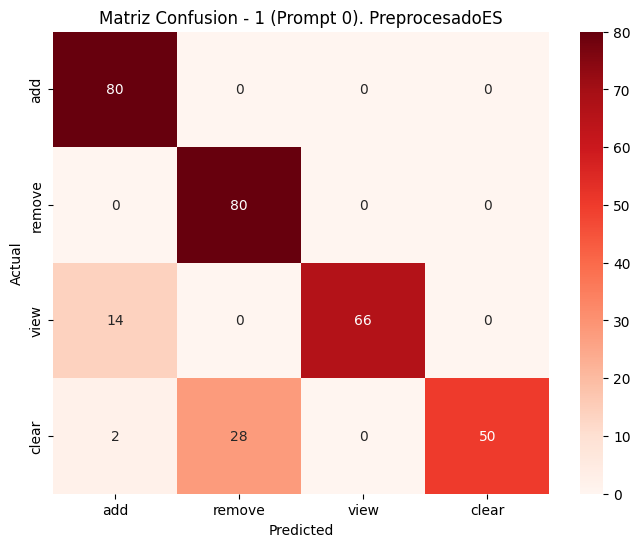

In [ ]:
# Evaluar predicciones y obtener las métricas
metrics = evaluate(Y_true, Y_pred, metodo2)

#### Grabado de las evaluaciones

In [ ]:
results_file = "/content/drive/MyDrive/Colab Notebooks/ft_falcon_model/resultados.csv"

# Comprobar si el archivo existe
if os.path.exists(results_file):
    # Si existe, cargar el CSV existente
    df_results = pd.read_csv(results_file)
else:
    # Si no existe, crear un DataFrame vacío
    df_results = pd.DataFrame(columns=['model', 'epochs', 'accuracy', 'precision_clear', 'recall_clear',
                                       'f1_score_clear', 'support_clear', 'precision_view', 'recall_view',
                                       'f1_score_view', 'support_view', 'precision_remove', 'recall_remove',
                                       'f1_score_remove', 'support_remove', 'precision_add', 'recall_add',
                                       'f1_score_add', 'support_add', 'matriz_path'])

# Crear una fila con las métricas y la información adicional
fila = {
    'model': model_name,
    'epochs': num_epochs,
    'accuracy': metrics['accuracy'],
    'precision_clear': metrics['precision_3'],
    'recall_clear': metrics['recall_3'],
    'f1_score_clear': metrics['f1_score_3'],
    'support_clear': metrics['support_3'],
    'precision_view': metrics['precision_2'],
    'recall_view': metrics['recall_2'],
    'f1_score_view': metrics['f1_score_2'],
    'support_view': metrics['support_2'],
    'precision_remove': metrics['precision_1'],
    'recall_remove': metrics['recall_1'],
    'f1_score_remove': metrics['f1_score_1'],
    'support_remove': metrics['support_1'],
    'precision_add': metrics['precision_0'],
    'recall_add': metrics['recall_0'],
    'f1_score_add': metrics['f1_score_0'],
    'support_add': metrics['support_0'],
    'matriz_path': metrics['matriz_path']
}

# Agregar la fila al DataFrame
df_results = pd.concat([df_results, pd.DataFrame([fila])], ignore_index=True)

# Guardar el DataFrame actualizado de nuevo en el archivo CSV
df_results.to_csv(results_file, index=False)

print(f"Métricas guardadas correctamente en {results_file}")